# Canal marítimo

### Importando las bibliotecas necesarias a utilizar 

In [60]:
import sys
import math
import random
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from heapq import heappush as push, heappop as pop

INFINITY = float('infinity')

### Métodos Auxiliares

In [61]:
def ExponentialVariable(lambda_):
    def ExponentialVar():
        return np.random.exponential(scale=1/lambda_)

    return ExponentialVar

def NormalVariable(mu = 0, sigma = 1):
    def NormalVar():
        return np.random.normal(mu, sigma)

    return NormalVar

# este método desplaza el horario en que se realizará el evento hacia un horario laborable, preferiblemente 8am
def put_eight_am (time):
    day_actual = int(time/1440) + (0 if time%1440 == 0 else 1)
    result = 0

    if time < 480:
        result = (day_actual-1)*1440 + 480
    else:
        result = day_actual*1440 + 480 + time - (int(time/1440)*1440 + 1200)

    return result

### Clases utilizadas en la simulación

In [62]:
class Process:
    def __init__(self, id, time):
        self.id = id # id del proceso 
        self.time = time # tiempo actual del proceso del proceso 

In [63]:
class Ship:
    def __init__(self, id, size, wait_time = 0, arrival_time = 0):
        self.id = id # id del barco
        self.size = size #tamaño del barco
        self.wait_time = wait_time # tiempo de espera del barco
        self.arrival_time = arrival_time # tiempo en el que arribó el barco
        self.process = -1 # id del proceso asociado a dicho barco 

In [64]:
class Dam:
    def __init__(self):
        self.queue = [] # cola de barcos de espera para entrar al dique
        self.inside = [] # barcos que se encuentran en el interior dediqueeu

        ## self.start_time se refiere al momento de entrada de los diques y self.finish_time al tiempo de salida de los barcos del dique 
        self.start_time = INFINITY
        self.finish_time = INFINITY

    # este método guarda a los barcos en el dique correspondiente y devuelve el tiempo que se demoró en entrar a los barcos al dique
    def get_ships_into(self, number_process, lambda_):
        self.inside = []
        first_row = 0 #inicializamos la primera fila
        second_row = 0 #inicializamos la segunda fila

        process_lifespan = 0 # tiempo que durará el proceso

        queue_copy = []
        for ship in self.queue:
            queue_copy.append(ship)

        for ship in queue_copy:
            if first_row + ship.size <= 6:
                #ponerlo en la primera fila
                first_row = first_row + ship.size
            elif second_row + ship.size <= 6:
                #ponerlo en la segunda fila
                second_row = second_row + ship.size
            elif first_row == second_row == 6:
                #el dique está lleno
                break
            else:
                #este barco no cabe en el dique
                continue
            
            ship.process = number_process
            self.inside.append(ship)

            #generar el tiempo que demora este barco en entrar al dique, y contarlo
            process_lifespan = process_lifespan + ExponentialVariable(lambda_)()

            #quitarlo de la cola
            self.queue.remove(ship)

        return process_lifespan

    def is_empty(self):
        return self.start_time == self.finish_time == INFINITY

### A continuación se presenta la clase principal de la simulación Maritime Canal, donde se efectúa la llamada al comienzo de la simulación

In [65]:
class MaritimeCanal:

    def __init__(self, days, params_normal, params_exponential):
        self.T = days*24*60 #tiempo total de la simulación
        self.N = 5 #cantidad de diques
        self.number_process = -1  # id del ultimo proceso que comenzó
        self.process = [] # cola de procesos activos
        self.params_normal = params_normal
        self.params_exponential = params_exponential
        self.simulation_ships = []
    
    # función que genera el arribo de los barcos y los mete en un heap de eventos
    def _generate_ships_arrival(self):
        id_ships = 0

        for i in range(0,3):
            time = 0

            while time < self.T: # mientras esté dentro del tiempo de la simulación
                scale_time = time%1440
                normal = 0

                # verificar el horario que le corresponde a dicho barco
                if 480 <= scale_time and scale_time < 660:
                    normal = NormalVariable(self.params_normal[i][0][0], self.params_normal[i][0][1])()
                elif 660 <= scale_time and scale_time < 1020:
                    normal = NormalVariable(self.params_normal[i][1][0], self.params_normal[i][1][1])()
                elif 1020 <= scale_time and scale_time < 1200:
                    normal = NormalVariable(self.params_normal[i][2][0], self.params_normal[i][2][1])()
                else:
                    normal = NormalVariable(self.params_normal[i][3][0], self.params_normal[i][3][1])()

                if normal > 0:
                    time += normal
                    id_ships += 1

                    if time < self.T:
                        ship = Ship(id_ships, 2**i, 0, time)
                        self.event_id += 1
                        push(self.events, (ship.arrival_time, self.event_id, self._ship_arrival(ship)))   

    def _initialize(self):
        self.total_ships_through_canal = 0 # total de barcos que atraviesan el canal 
        self.dams = [Dam() for i in range(self.N)] #lista de diques
        self.T_t = 0 #tiempo total de espera de los barcos
        self.events = [] # heap de eventos a ejecutar
        self.event_id = -1
        self._generate_ships_arrival()

    # Este evento maneja el arribo de los barcos
    def _ship_arrival(self, ship):
        def _ship_arrival_i():
            
            if self.dams[0].is_empty() and self.dams[0].queue == []:
                # calcular comienzo del proceso, después de abrir las compuertas
                exponential_var = ExponentialVariable(self.params_exponential[0])()
                start_process_time = ship.arrival_time + exponential_var

                # verificar que si el evento se realiza en horario no laborable, actualizar su horario para el otro dia
                scale_time = start_process_time%1440
                if scale_time < 480  or 1200 <= scale_time:
                    start_process_time = put_eight_am(start_process_time)
                    if scale_time < 480:  
                        start_process_time += exponential_var

                # verificar que el evento de entrada al primer dique se va a realizar dentro del tiempo de la simulación
                if start_process_time < self.T:
                    self.dams[0].start_time = start_process_time

                    # crear un nuevo proceso
                    self.number_process = self.number_process+1
                    self.process.append(Process(self.number_process, self.dams[0].start_time))

                    #generar un evento de entrada al primer dique
                    self.event_id += 1
                    push(self.events, (self.dams[0].start_time, self.event_id, self._start_dam(0, self.number_process))) 


            #añadirlo a la cola del primer dique
            self.dams[0].queue.append(ship)
        
        return  _ship_arrival_i

    def _start_dam(self, i, number_process):
        def _start_dam_i():
        
            #actualizar el tiempo del proceso
            self.process[number_process].time = self.dams[i].start_time
            
            #entrar los barcos al dique
            lifespan = self.dams[i].get_ships_into(number_process, self.params_exponential[1])

            #sumar el tiempo de la fase de transporte
            lifespan = lifespan + ExponentialVariable(self.params_exponential[2])()

            #sumar el tiempo de la salida de los barcos
            for ship in self.dams[i].inside:
                lifespan = lifespan + ExponentialVariable(self.params_exponential[3])()

            transportation_time = self.process[number_process].time + lifespan

            # verificar que si el evento se realiza en horario no laborable, actualizar su horario para el otro dia
            scale_time = transportation_time%1440
            if scale_time < 480  or 1200 <= scale_time:
                transportation_time = put_eight_am(transportation_time) 

            # verificar que el evento finish_dam se va a realizar dentro del tiempo de la simulación
            if transportation_time < self.T:
                self.dams[i].finish_time = transportation_time

                #generar un evento de salida de este dique
                self.event_id += 1
                push(self.events, (self.dams[i].finish_time, self.event_id, self._finish_dam(i, number_process)))

            
            self.dams[i].start_time = INFINITY

        return _start_dam_i

    def _finish_dam(self, i, number_process):
        def _finish_dam_i():
            
            #actualizar el tiempo de la simulación
            self.process[number_process].time = self.dams[i].finish_time

            if i < self.N - 1:

                if self.dams[i+1].is_empty() and self.dams[i+1].queue == []:
                    # calcular el tiempo después de abrir las compuertas
                    open_gates_time = self.process[number_process].time + ExponentialVariable(self.params_exponential[0])()

                    # verificar que si el evento se realiza en horario no laborable, actualizar su horario para el otro dia
                    scale_time = open_gates_time%1440
                    if scale_time < 480  or 1200 <= scale_time:
                        open_gates_time = put_eight_am(open_gates_time)
                    
                    # verificar que el evento de entrada al i-ésimo + 1 dique se va a realizar dentro del tiempo de la simulación
                    if open_gates_time < self.T:
                        self.dams[i+1].start_time = open_gates_time 

                        #generar un evento de entrada al i-ésimo + 1 dique
                        self.event_id += 1
                        push(self.events, (self.dams[i+1].start_time, self.event_id, self._start_dam(i+1, number_process)))

                #poner los barcos en la cola del dique siguiente
                for ship in self.dams[i].inside:
                    self.dams[i+1].queue.append(ship)
            else:
                for ship in self.dams[i].inside:
                    ship.wait_time = self.process[number_process].time - ship.arrival_time
                    self.T_t += ship.wait_time
                    self.total_ships_through_canal += 1
                    self.simulation_ships.append(ship)
            
            self.dams[i].inside = []

            if self.dams[i].queue != []:
                if i == 0:
                    # calcular el tiempo después de abrir las compuertas
                    open_gates_time_2 = self.process[number_process].time + ExponentialVariable(self.params_exponential[0])()

                    # verificar que si el evento se realiza en horario no laborable, actualizar su horario para el otro dia
                    scale_time = open_gates_time_2%1440
                    if scale_time < 480  or 1200 <= scale_time:                   
                        open_gates_time_2 = put_eight_am(open_gates_time_2)
                    
                    # verificar que el evento de entrada al primer dique se va a realizar dentro del tiempo de la simulación
                    if open_gates_time_2 < self.T:
                        self.dams[0].start_time = open_gates_time_2

                        # crear un nuevo proceso
                        self.number_process = self.number_process+1
                        self.process.append(Process(self.number_process, self.dams[0].start_time))

                        #generar un evento de entrada al primer dique
                        self.event_id += 1
                        push(self.events, (self.dams[0].start_time, self.event_id, self._start_dam(0, self.number_process)))

                else:    
                    # calcular el tiempo después de abrir las compuertas
                    open_gates_time_1 = self.process[number_process].time + ExponentialVariable(self.params_exponential[0])()

                    # verificar que si el evento se realiza en horario no laborable, actualizar su horario para el otro dia
                    scale_time = open_gates_time_1%1440
                    if scale_time < 480  or 1200 <= scale_time:
                        open_gates_time_1 = put_eight_am(open_gates_time_1) 
                    
                    # verificar que el evento de entrada al i-ésimo dique se va a realizar dentro del tiempo de la simulación
                    if open_gates_time_1 < self.T:
                        self.dams[i].start_time = open_gates_time_1

                        #generar un evento de entrada al i-ésimo dique
                        self.event_id += 1
                        push(self.events, (self.dams[i].start_time, self.event_id, self._start_dam(i, self.dams[i].queue[0].process)))

            self.dams[i].finish_time = INFINITY
        return _finish_dam_i

    def start_simulation(self):
       
        self._initialize()

        current_event = None
        while len(self.events) > 0:
            _, _, current_event = pop(self.events)
            current_event()
    

#### Para probar la simulación puede manejar los siguientes parámetros como desee:

In [66]:
# Tabla de los parámetros de la función normal para cada barco en diferente horario
matrix =  [
    # 8-11am  11am-5pm   5-8pm    8pm-8am
    [(5,2),   (3,1),     (10,2),  (6,1)], # Pequeño
    [(15,3),  (10,5),    (20,5),  (15,4)], # Mediano
    [(45,3),  (35,7),    (60,9),  (46,6)] # Grande
]

days_simulation = 30

                            #  Lambdas:
params_exponential = [4,    # Aperturas de las compuertas
                      2,    # Entradas de los barcos al dique
                      7,    # Fase de transporte
                      1.5]  # Salida del dique

Analizando el comportamiento de la desviación estándar

In [67]:
num_simulations = 10

In [68]:
all_ships = []
sum_wait_time = 0
before_params = []

for i in range(0,num_simulations):
    maritime_canal = MaritimeCanal(days_simulation, matrix, params_exponential) # days of the simulation
    maritime_canal.start_simulation()

    print ('-----------------------------------------------------------------------')
    print ('\tRESULTS OF THE SIMULATION')
    
    average_wait_time_for_ship = (maritime_canal.T_t / maritime_canal.total_ships_through_canal)/60
    print ('Average waiting time for ship = %s hours' %(average_wait_time_for_ship))
    ships_go_through_canal = maritime_canal.total_ships_through_canal
    print ('Total ships that go through tha maritime canal = %s' %(ships_go_through_canal))
    before_params.append(ships_go_through_canal)
    simulation_ships = maritime_canal.simulation_ships
    all_ships.extend(simulation_ships)
    sum_wait_time+=maritime_canal.T_t


-----------------------------------------------------------------------
	RESULTS OF THE SIMULATION
Average waiting time for ship = 5.017568127091037 hours
Total ships that go through tha maritime canal = 12871
-----------------------------------------------------------------------
	RESULTS OF THE SIMULATION
Average waiting time for ship = 5.036250829875077 hours
Total ships that go through tha maritime canal = 12822
-----------------------------------------------------------------------
	RESULTS OF THE SIMULATION
Average waiting time for ship = 5.004420307958593 hours
Total ships that go through tha maritime canal = 12848
-----------------------------------------------------------------------
	RESULTS OF THE SIMULATION
Average waiting time for ship = 4.97693924067693 hours
Total ships that go through tha maritime canal = 12853
-----------------------------------------------------------------------
	RESULTS OF THE SIMULATION
Average waiting time for ship = 5.0043312310413715 hours
Total

In [69]:
ships_wait_time = []
for ship in simulation_ships:
    ships_wait_time.append(ship.wait_time)


In [70]:
mean = np.mean(ships_wait_time)
std = np.std(ships_wait_time, ddof=1)
print ('Mean = %s' %(mean))
print ('Standard deviation = %s' %(std))

Mean = 303.0352320469471
Standard deviation = 228.92708870991433


Una media de 303 y una desviación estándar de 228 sugieren que los datos muestran una alta variabilidad, con una dispersión considerable de los valores alrededor de la media.

### Creamos un nuevo canal marítimo con los mismos parámetros e iniciamos su simulación durante 30 días para ver como se comportan las variables de interés

In [71]:
maritime_canal = MaritimeCanal(days_simulation, matrix, params_exponential) # days of the simulation
maritime_canal.start_simulation()
print ('-----------------------------------------------------------------------')
print ('\tRESULTS OF THE SIMULATION')
average_wait_time_for_ship = (maritime_canal.T_t / maritime_canal.total_ships_through_canal)/60
print ('Average waiting time for ship = %s hours' %(average_wait_time_for_ship))
ships_go_through_canal = maritime_canal.total_ships_through_canal
print ('Total ships that go through that maritime canal = %s' %(ships_go_through_canal))
ships_sorted = sorted(maritime_canal.simulation_ships, key=lambda x: x.arrival_time)

ships_arrivals = [ship.arrival_time for ship in ships_sorted]
ships_wait = [ship.wait_time + ship.arrival_time for ship in ships_sorted]  

-----------------------------------------------------------------------
	RESULTS OF THE SIMULATION
Average waiting time for ship = 5.0313807793099805 hours
Total ships that go through that maritime canal = 12809


### Ploteamos algunos gráficos que nos proporcionan información acerca de la simulación

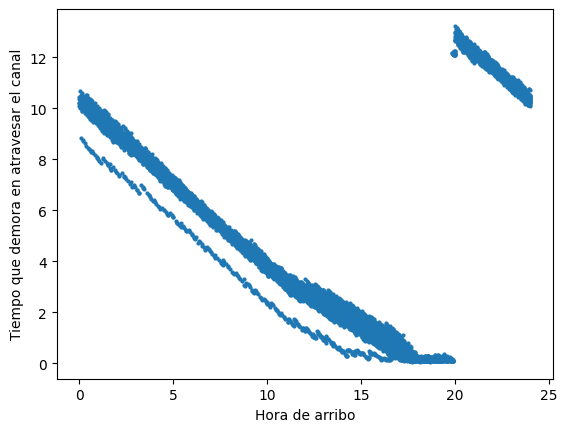

In [72]:
ships_arrival_time = [(ship.arrival_time%1440)/60 for ship in ships_sorted]
ships_wait = [ship.wait_time/60 for ship in ships_sorted]

plt.scatter(ships_arrival_time, ships_wait, s = 4)
plt.xlabel('Hora de arribo')
plt.ylabel('Tiempo que demora en atravesar el canal')

plt.show()

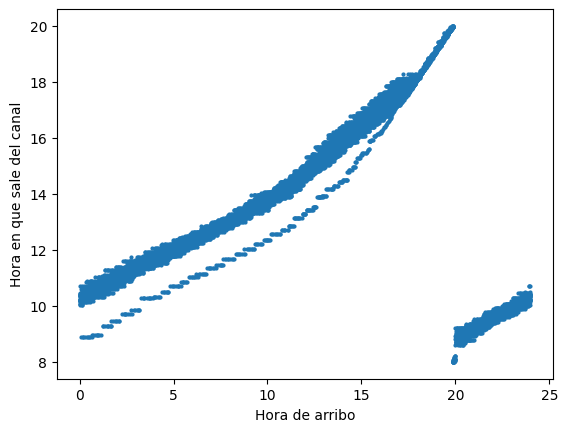

In [73]:
ships_leave_time = [((ship.arrival_time+ship.wait_time)%1440)/60 for ship in ships_sorted]

plt.scatter(ships_arrival_time, ships_leave_time, s=4)
plt.xlabel('Hora de arribo')
plt.ylabel('Hora en que sale del canal')

plt.show()

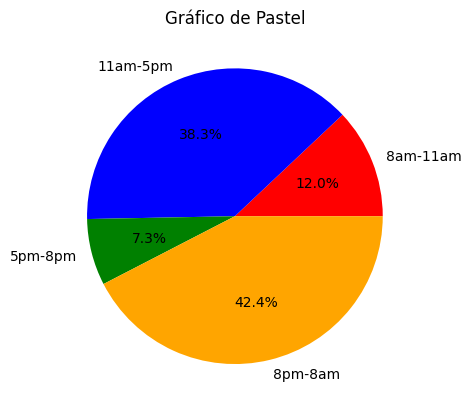

In [74]:
import matplotlib.pyplot as plt

# Datos para las porciones del pastel
sizes = [0,0,0,0]

for ship in ships_sorted:
    arr_time = (ship.arrival_time%1440)/60
    if 8 <= arr_time and arr_time < 11:
        sizes[0] += 1
    elif 11 <= arr_time and arr_time < 17:
        sizes[1] += 1
    elif 17 <= arr_time and arr_time < 20:
        sizes[2] += 1
    else:
        sizes[3] += 1


# Etiquetas para cada porción
labels = ['8am-11am', '11am-5pm', '5pm-8pm', '8pm-8am']

# Colores para cada porción
colors = ['red', 'blue', 'green', 'orange']

# Crear el gráfico de pastel
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%')

# Agregar un título
plt.title('Gráfico de Pastel')

# Mostrar el gráfico
plt.show()

Ahora realizaremos la prueba de hipótesis para comprobrar que al aumentar la media de la distribución de los barcos pequeños y disminuir la media de la distribución de los grandes en una pequeña proporción, disminuye la cantidad de barcos que atraviesan el canal.

In [75]:
# Tabla de los parámetros de la función normal para cada barco en diferente horario
matrix =  [
    # 8-11am  11am-5pm   5-8pm    8pm-8am
    [(6,2),   (3.6,1),   (12,2),  (7.2,1)], # Pequeño
    [(15,3),  (10,5),    (20,5),  (15,4)], # Mediano
    [(36,3),  (28,7),    (48,9),  (36.8,6)] # Grande
]

after_params = []
for i in range(0,num_simulations):
    maritime_canal = MaritimeCanal(days_simulation, matrix, params_exponential) # days of the simulation
    maritime_canal.start_simulation()
    print ('-----------------------------------------------------------------------')
    print ('\tRESULTS OF THE SIMULATION')
    average_wait_time_for_ship = (maritime_canal.T_t / maritime_canal.total_ships_through_canal)/60
    ships_go_through_canal_other = maritime_canal.total_ships_through_canal
    print ('Total ships that go through that maritime canal = %s' %(ships_go_through_canal_other))
    after_params.append(ships_go_through_canal_other)
    ships_sorted = sorted(maritime_canal.simulation_ships, key=lambda x: x.arrival_time)

    if ships_go_through_canal_other < ships_go_through_canal:
        print('The hypothesis is fulfilled (%s < %s)' %(ships_go_through_canal_other, ships_go_through_canal))
    else:
        print ('The hypothesis isn\'t fulfilled, because the new value is greater than the first one')

    ships_arrivals = [ship.arrival_time for ship in ships_sorted]
    ships_wait = [ship.wait_time + ship.arrival_time for ship in ships_sorted]    

-----------------------------------------------------------------------
	RESULTS OF THE SIMULATION
Total ships that go through tha maritime canal = 11573
The hypothesis is fulfilled (11573 < 12809)
-----------------------------------------------------------------------
	RESULTS OF THE SIMULATION
Total ships that go through tha maritime canal = 11591
The hypothesis is fulfilled (11591 < 12809)
-----------------------------------------------------------------------
	RESULTS OF THE SIMULATION
Total ships that go through tha maritime canal = 11675
The hypothesis is fulfilled (11675 < 12809)
-----------------------------------------------------------------------
	RESULTS OF THE SIMULATION
Total ships that go through tha maritime canal = 11649
The hypothesis is fulfilled (11649 < 12809)
-----------------------------------------------------------------------
	RESULTS OF THE SIMULATION
Total ships that go through tha maritime canal = 11598
The hypothesis is fulfilled (11598 < 12809)
----------

Tras simular n veces la travesía de los barcos en su intento por cruzar el canal durante 30 días con los parámetros viejos y los nuevos, se comprobó lo planteado.
Luego se realizó una prueba t de Student para ver si la diferencia resultó significativa.

In [76]:
alpha = 0.05

# Prueba t para muestras independientes
t_stat, p_value = stats.ttest_ind(before_params, after_params)

print(f'T-statistic: {t_stat}')
print(f'P-value: {p_value}')

# Comparar el p-valor con el nivel de significancia
if p_value < alpha:
    print(f'La diferencia es significativa (p < {alpha})')
else:
    print(f'La diferencia no es significativa (p >= {alpha})')

T-statistic: 90.71469227951319
P-value: 2.086493085908421e-25
La diferencia es significativa (p < 0.05)


La diferencia resultó significativa, lo que quiere decir que bajo el nivel de confianza elegido, la evidencia de los datos sugiere que hay una diferencia real entre los barcos que atraviesan el canal, para diferentes configuraciones de los parámetros. En otra palabras, es poco probable que esta diferencia sea debido al azar.
Dado que el resultado es significativo, se rechaza la hipótesis nula, la cual es que no hay diferencia significativa en la cantidad de barcos que atraviesan el canal con diferentes parámetros. 

#### Ploteando nuevamente los gráficos

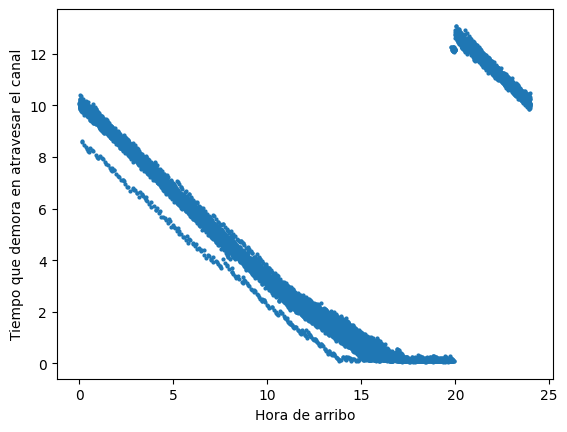

In [77]:
ships_arrival_time = [(ship.arrival_time%1440)/60 for ship in ships_sorted]
ships_wait = [ship.wait_time/60 for ship in ships_sorted]

plt.scatter(ships_arrival_time, ships_wait, s = 4)
plt.xlabel('Hora de arribo')
plt.ylabel('Tiempo que demora en atravesar el canal')

plt.show()

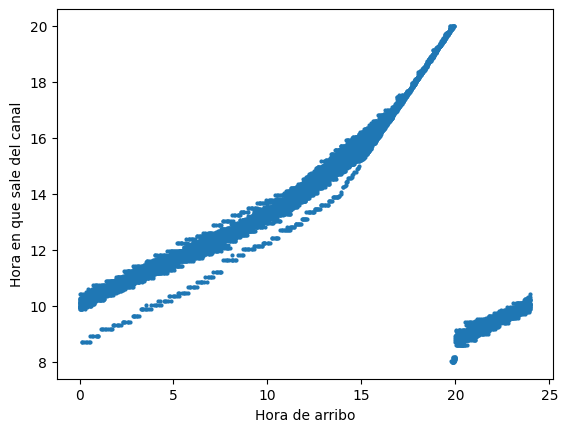

In [78]:
ships_leave_time = [((ship.arrival_time+ship.wait_time)%1440)/60 for ship in ships_sorted]

plt.scatter(ships_arrival_time, ships_leave_time, s=4)
plt.xlabel('Hora de arribo')
plt.ylabel('Hora en que sale del canal')

plt.show()

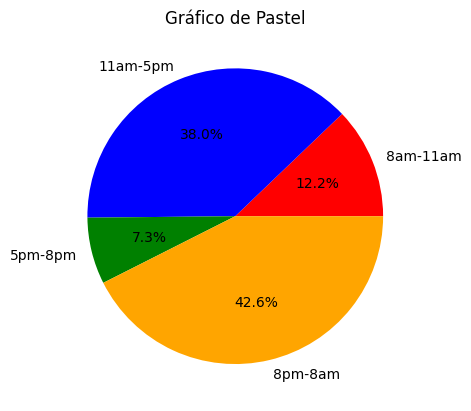

In [79]:
import matplotlib.pyplot as plt

# Datos para las porciones del pastel
sizes = [0,0,0,0]

for ship in ships_sorted:
    arr_time = (ship.arrival_time%1440)/60
    if 8 <= arr_time and arr_time < 11:
        sizes[0] += 1
    elif 11 <= arr_time and arr_time < 17:
        sizes[1] += 1
    elif 17 <= arr_time and arr_time < 20:
        sizes[2] += 1
    else:
        sizes[3] += 1


# Etiquetas para cada porción
labels = ['8am-11am', '11am-5pm', '5pm-8pm', '8pm-8am']

# Colores para cada porción
colors = ['red', 'blue', 'green', 'orange']

# Crear el gráfico de pastel
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%')

# Agregar un título
plt.title('Gráfico de Pastel')

# Mostrar el gráfico
plt.show()